# Simple California Demo 2.0



This notebook shows how to use build a hierarchical clustering of the input features and use it to explain a single instance. It will showcase two method to do this:

The PartitionExplainer which creates a binary-hierarchal clustering of features using your choice of scipy clustering methods. The PartitionExplainer then caculates the feature attribution with the marginals respecting this binary partition tree. This is a good way to explain a single instance when the number of input features is large. When given a balanced partition tree PartitionExplainer has $O(M^2)$ runtime, where $M$ is the number of input features. This is much better than the $O(2^M)$ runtime of KernelExplainer.

The CoalitionExplainer allows more controll over the hierarchy of features. Users can specify any nested hierarchy of features as a dictionary. This means each node (group of features) gets allocated it's marginal contribution to all of its siblings allowing for more than one. So the computational complexity at each level is $O(2^K)$, where $K$ is the number of siblings, depends on the hierarchy of features specified. This method allows for more sensible explanations and a finer grained evaluation of the working of the model.

To clarify jargon Shapley values treat all input features as the same. Owen values are values respecting coalitions of features. Recursive Owen values also sometimes called Winter values respect nested coalitions.  

In [2]:
import time  # timing the methods

import matplotlib.pyplot as plt
import networkx as nx  # visualising the feature coalition structure
import numpy as np
import scipy as sp
import scipy.cluster
from xgboost import XGBRegressor  # The model we use is an XGBoost model

import shap

seed = 2023
np.random.seed(seed)

c:\programming\shap\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train a model

In [3]:
X, y = shap.datasets.california()
model = XGBRegressor(n_estimators=100, subsample=0.3)
model.fit(X, y)

instance = X[0:1]
references = X[1:100]

## Compute a hierarchical clustering of the input features

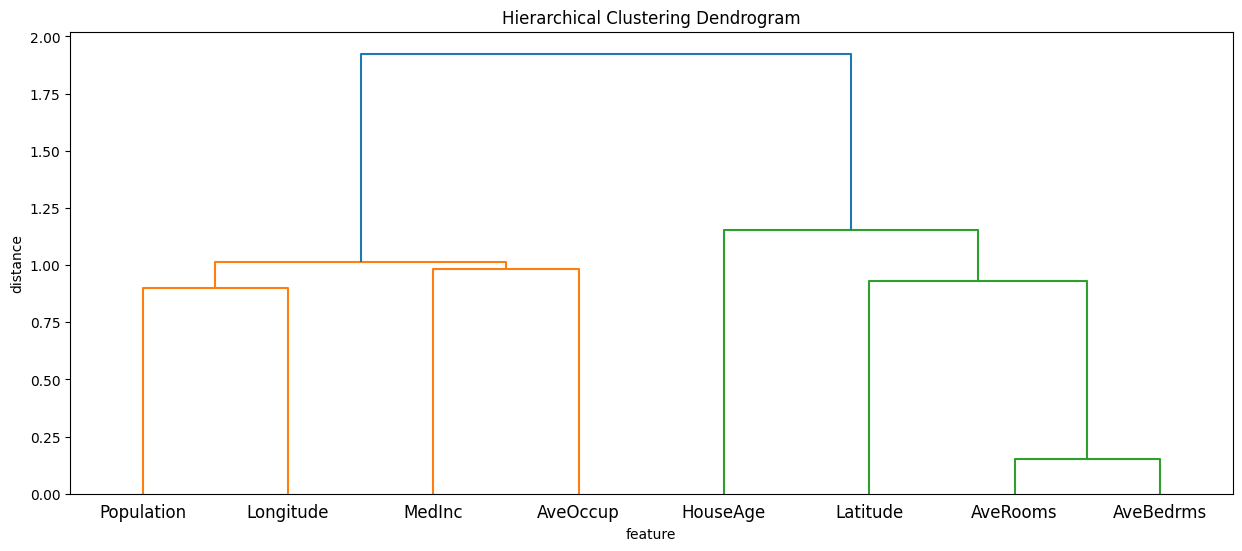

In [4]:
partition_tree = shap.utils.partition_tree(X)
plt.figure(figsize=(15, 6))
sp.cluster.hierarchy.dendrogram(partition_tree, labels=X.columns)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
plt.show()

## Explain the instance

To demonstrate the new behaviour of the CoalitionExplainer and check if it works correctly we can use the ExactExplainer and PartitionExplainer methods

Theoretically if we pass a flat hierarchy to CoalitionExplainer it should return the same result as the ExactExplainer.

If we turn the linkage matrix PartitionExplainer uses to a dictionary and pass it to the CoalitionExplainer it should return the exact same result as the Partition Explainer

In [5]:
# function to turn the linkage matrix to a dictionary
def build_partition_hierarchy(linkage, labels):
    n = len(labels)
    cluster_dict = {}

    # Initialize leaves
    for i in range(n):
        cluster_dict[i] = labels[i]

    # Build clusters
    for i, row in enumerate(linkage):
        idx1 = int(row[0])
        idx2 = int(row[1])
        cluster_id = n + i  # New cluster index

        # Create cluster names
        if idx1 < n:
            left = cluster_dict[idx1]
        else:
            left = f"cluster_{idx1}"

        if idx2 < n:
            right = cluster_dict[idx2]
        else:
            right = f"cluster_{idx2}"

        # Create the new cluster
        cluster_dict[cluster_id] = {left: cluster_dict[idx1], right: cluster_dict[idx2]}

    # The root cluster
    root_cluster_id = n + len(linkage) - 1
    return {f"cluster_{root_cluster_id}": cluster_dict[root_cluster_id]}


hierarchy_binary = build_partition_hierarchy(partition_tree, X.columns)

Now we can also create a flat hierarchy and a couple non-binary hierarchies to test the method. 

In [6]:
# exact partition hierarchy flat
hierarchy_flat = {
    "AveOccup": "AveOccup",
    "MedInc": "MedInc",
    "Longitude": "Longitude",
    "Population": "Population",
    "HouseAge": "HouseAge",
    "Latitude": "Latitude",
    "AveBedrms": "AveBedrms",
    "AveRooms": "AveRooms",
}

# custom partition
hierarchy_nonbinary = {
    "HouseCharacteristics": {
        "AveBedrms": "AveBedrms",
        "AveRooms": "AveRooms",
        "AveOccup": "AveOccup",
        "HouseAge": "HouseAge",
    },
    "Area": {
        "Location": {"Latitude": "Latitude", "Longitude": "Longitude"},
        "Neighbours": {"MedInc": "MedInc", "Population": "Population"},
    },
}
# custom partition
hierarchy_nonbinary2 = {
    "Activity": {
        "MedInc": "MedInc",
        "AveOccup": "AveOccup",
        "Population": "Population",
    },
    "Material": {
        "AveBedrms": "AveBedrms",
        "AveRooms": "AveRooms",
        "HouseAge": "HouseAge",
    },
    "Location": {"Latitude": "Latitude", "Longitude": "Longitude"},
}

Now we can test the Coalition method and see how it perfroms. 
Is it correct in extending the Shapley value methods?
How does it perform in terms of speed compared to the other methods?

In [7]:
# Exact Shap values
start_time = time.time()
exact_explainer = shap.ExactExplainer(model.predict, X)
exact_shap_values = exact_explainer(references)
print(f"Exact Shap values computed in {time.time() - start_time:.2f} seconds")

# Tree Shap values
start_time = time.time()
tree_explainer = shap.TreeExplainer(model, X)
tree_shap_values = tree_explainer(references)
print(f"Tree Shap values computed in {time.time() - start_time:.2f} seconds")

# Old binary winter values
start_time = time.time()
masker_explainer = shap.PartitionExplainer(model.predict, X)
binary_winter_values = masker_explainer(references)
print(f"Binary Winter values computed in {time.time() - start_time:.2f} seconds")

# We can precompute the masker making the computation faster
start_time = time.time()
# build a masker from partition tree
masker = shap.maskers.Partition(X, clustering=partition_tree)
masker_explainer = shap.PartitionExplainer(model.predict, masker)
masker_winter_values = masker_explainer(references)
print(f"Binary Winter values specifying the tree computed in {time.time() - start_time:.2f} seconds")


# Shapley values corresponding to flat hierarchy
start_time = time.time()
partition_masker = shap.maskers.Partition(X)
partition_explainer_f = shap.CoalitionExplainer(model.predict, partition_masker, partition_tree=hierarchy_flat)
partition_winter_values_f = partition_explainer_f(references)
print(f"Partition Winter values (flat hierarchy) computed in {time.time() - start_time:.2f} seconds")
print(
    "The Coalition explainer recreates the ExactExplainer Shapley values:",
    np.allclose(exact_shap_values.values, partition_winter_values_f.values),
)

# Recreating the old binary winter values
start_time = time.time()

partition_explainer = shap.CoalitionExplainer(model.predict, partition_masker, partition_tree=hierarchy_binary)
partition_winter_values_b = partition_explainer(references)
print(f"Partition Winter values (binary hierarchy) computed in {time.time() - start_time:.2f} seconds")
print(
    "The Coalition explainer recreates the PartitionExplainer Winter values:",
    np.allclose(masker_winter_values.values, partition_winter_values_b.values),
)


# Shapley values for non-binary hierarchy
start_time = time.time()
partition_explainer_nb = shap.PartitionExplainer(model.predict, partition_masker, partition_tree=hierarchy_nonbinary)
partition_winter_values_nb = partition_explainer_nb(references)
print(f"Partition Winter values (non-binary hierarchy) computed in {time.time() - start_time:.2f} seconds")

# Shapley values for another non-binary hierarchy
start_time = time.time()
partition_explainer_nb2 = shap.PartitionExplainer(model.predict, partition_masker, partition_tree=hierarchy_nonbinary2)
partition_winter_values_nb2 = partition_explainer_nb2(references)
print(f"Partition Winter values (non-binary hierarchy 2) computed in {time.time() - start_time:.2f} seconds")

ExactExplainer explainer: 100it [00:10,  3.29it/s]                       


Exact Shap values computed in 10.94 seconds
Tree Shap values computed in 0.42 seconds
Binary Winter values computed in 5.39 seconds
Binary Winter values specifying the tree computed in 2.17 seconds


CoalitionExplainer explainer: 100it [00:26,  2.26it/s]                       


Partition Winter values (flat hierarchy) computed in 26.53 seconds
The Coalition explainer recreates the ExactExplainer Shapley values: True
Partition Winter values (binary hierarchy) computed in 6.04 seconds
The Coalition explainer recreates the PartitionExplainer Winter values: True
Partition Winter values (non-binary hierarchy) computed in 4.05 seconds
Partition Winter values (non-binary hierarchy 2) computed in 4.15 seconds


## Compare to Tree SHAP

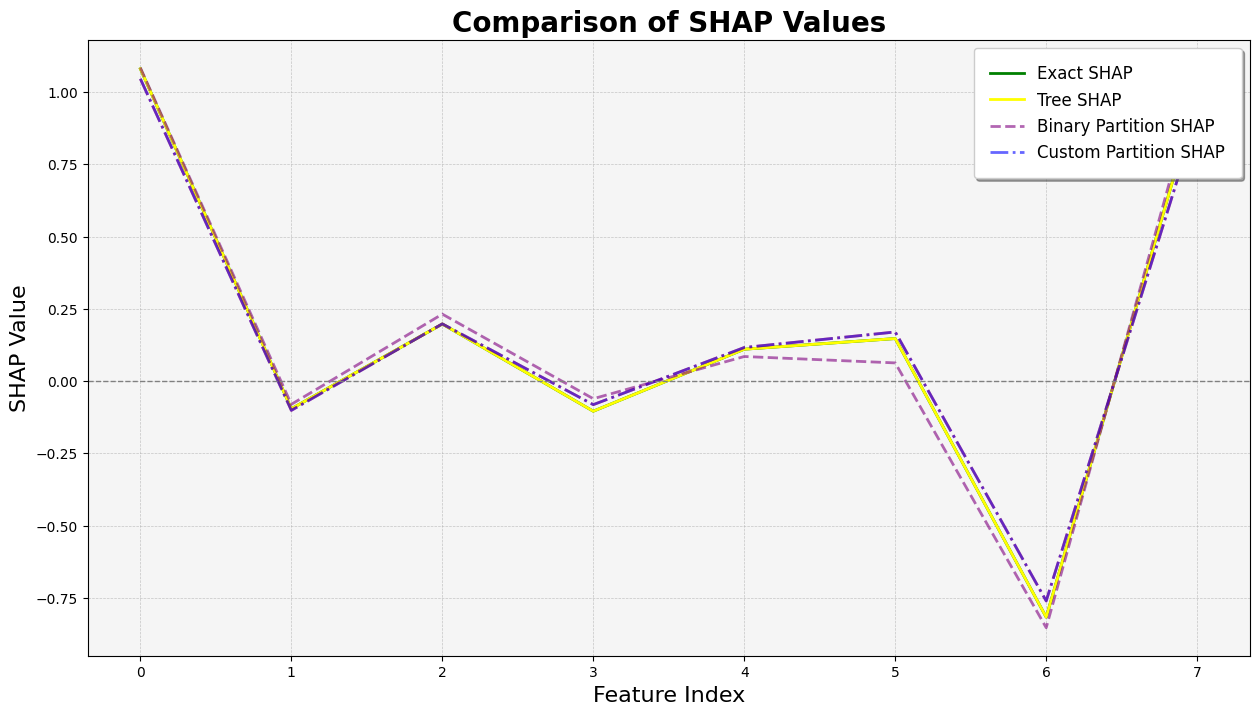

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Plot the SHAP values with enhanced visibility
plt.plot(
    exact_shap_values.values[0],
    linestyle="-",
    linewidth=2,
    label="Exact SHAP",
    color="green",
)
plt.plot(
    tree_shap_values.values[0],
    linestyle="-",
    linewidth=2,
    label="Tree SHAP",
    color="yellow",
    alpha=1,
)
plt.plot(
    binary_winter_values.values[0],
    linestyle="--",
    linewidth=2,
    label="Binary Partition SHAP",
    color="purple",
    alpha=0.6,
)
plt.plot(
    partition_winter_values_b.values[0],
    linestyle="-.",
    linewidth=2,
    label="Custom Partition SHAP",
    color="red",
    alpha=0.6,
)
plt.plot(
    partition_winter_values_b.values[0],
    linestyle="-.",
    linewidth=2,
    label="Custom Partition SHAP",
    color="blue",
    alpha=0.6,
)


# Adding title and labels with increased font sizes
plt.title("Comparison of SHAP Values", fontsize=20, fontweight="bold")
plt.xlabel("Feature Index", fontsize=16)
plt.ylabel("SHAP Value", fontsize=16)

# Customizing the legend for better readability
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper right",
    fontsize=12,
    frameon=True,
    fancybox=True,
    shadow=True,
    borderpad=1,
)

# Adding a grid for better readability
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Adding a light grey background
plt.gca().set_facecolor("whitesmoke")

# Adding a horizontal line at y=0 for reference
plt.axhline(0, color="grey", linestyle="--", linewidth=1)

# Display the plot
plt.show()

Partition SHAP values using a partition tree are nice estimation of SHAP values. The partition tree is a good way to reduce the number of input features and speed up the computation.

The thinking for why the attributions are so close to the Shapley values is that for each feature the marginal is computed to all the other features masked as well as all of them unmasked which bound the feature's attribution.

## Plots to explain the instance

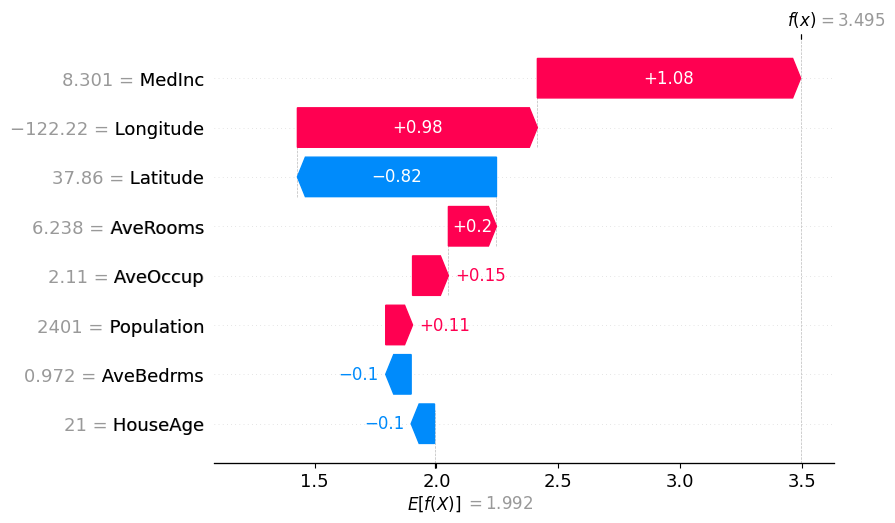

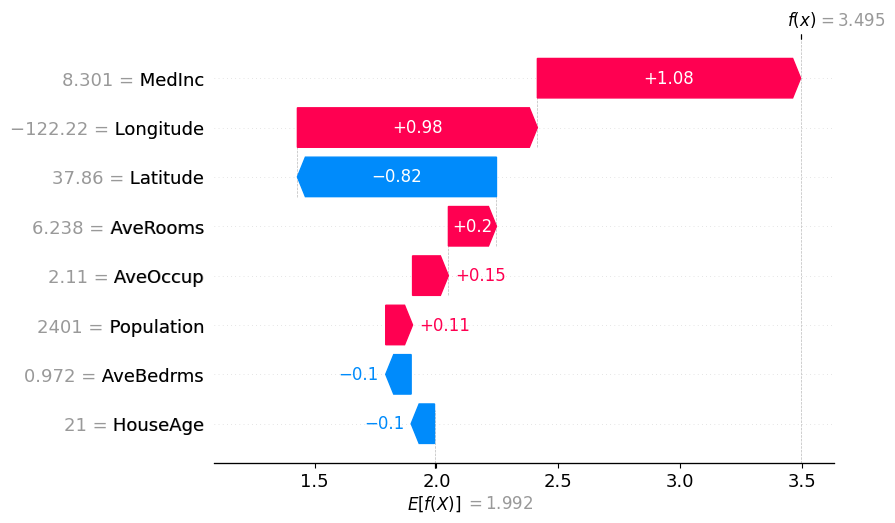

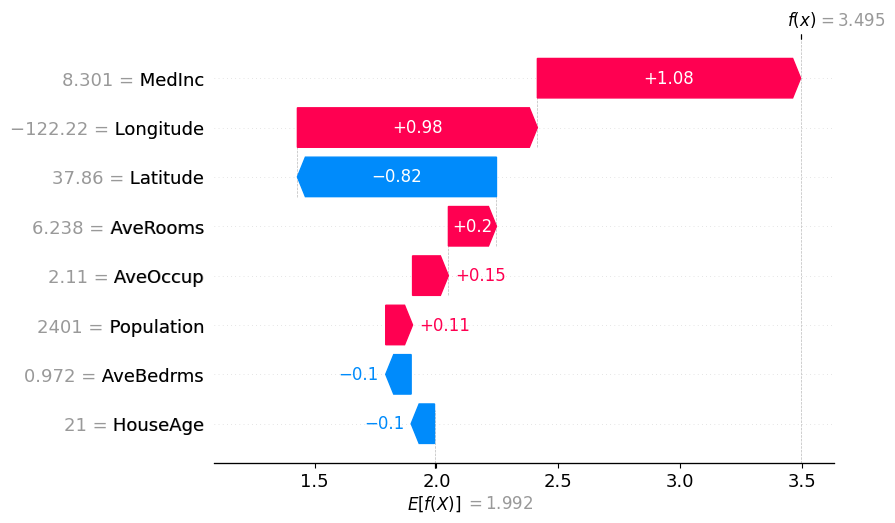

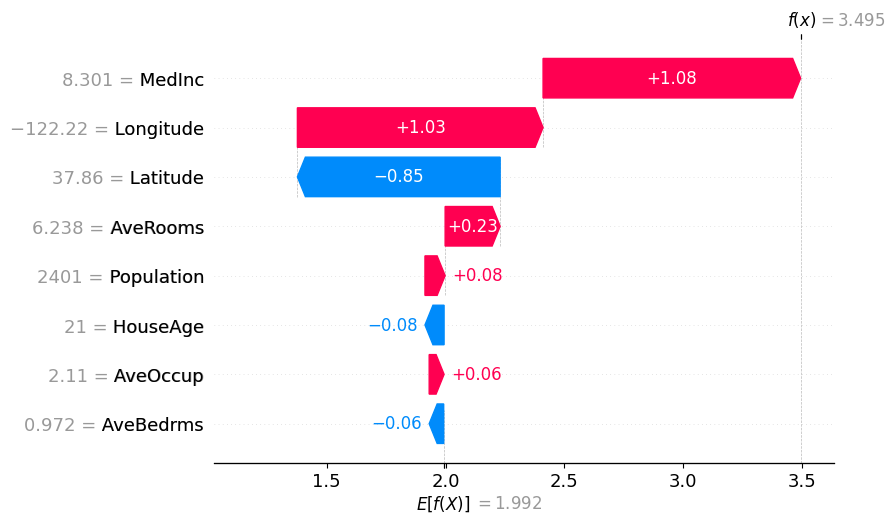

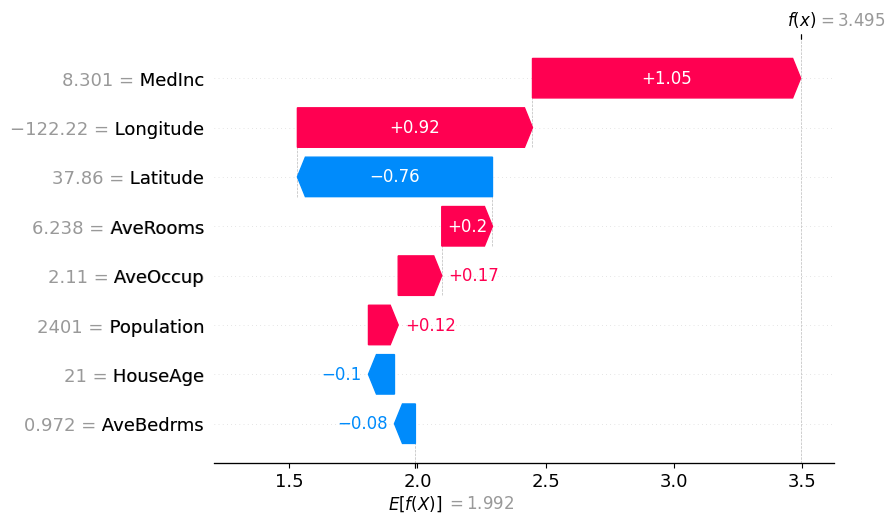

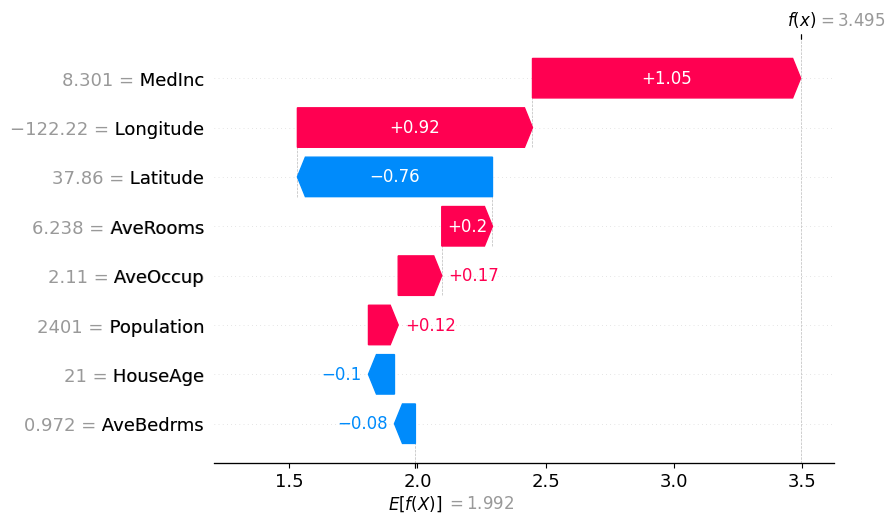

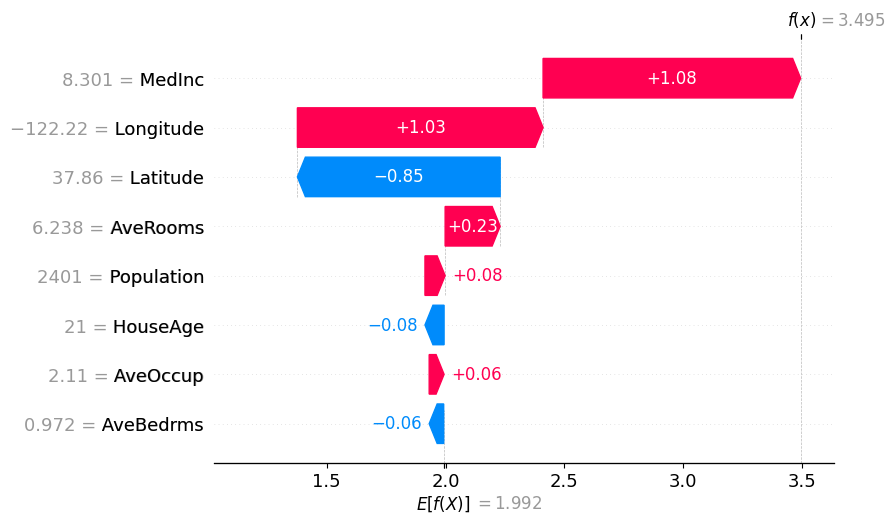

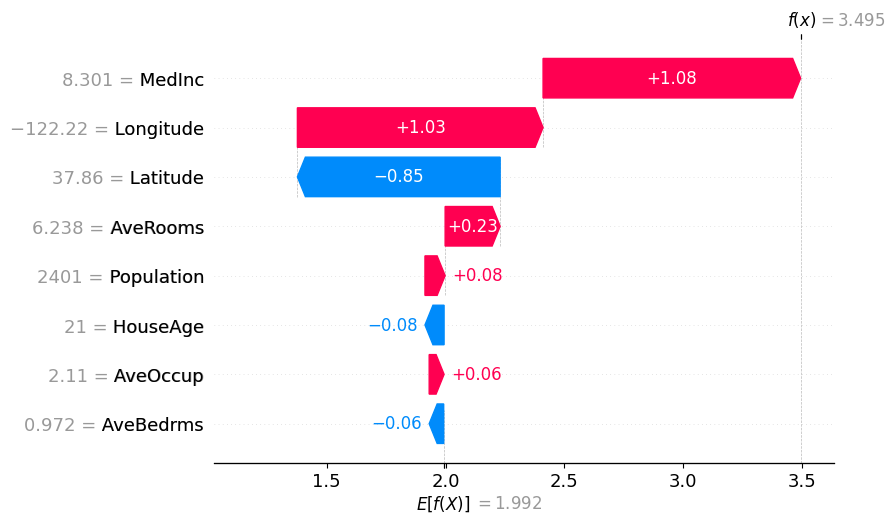

In [9]:
# The exact Shap values
shap.plots.waterfall(exact_shap_values[0])

shap.plots.waterfall(tree_shap_values[0])

shap.plots.waterfall(partition_winter_values_f[0])  # This should match the previous


# Binary Winter values
shap.plots.waterfall(binary_winter_values[0])

# Binary Winter values specifying the partition_tree
shap.plots.waterfall(masker_winter_values[0])

# Partition Winter values (binary hierarchy but with the new method)
shap.plots.waterfall(partition_winter_values_b[0])  # This should match the previous


# Partition Winter values (non-binary hierarchy)
shap.plots.waterfall(partition_winter_values_nb[0])
# Partition Winter values (non-binary hierarchy)
shap.plots.waterfall(partition_winter_values_nb2[0])

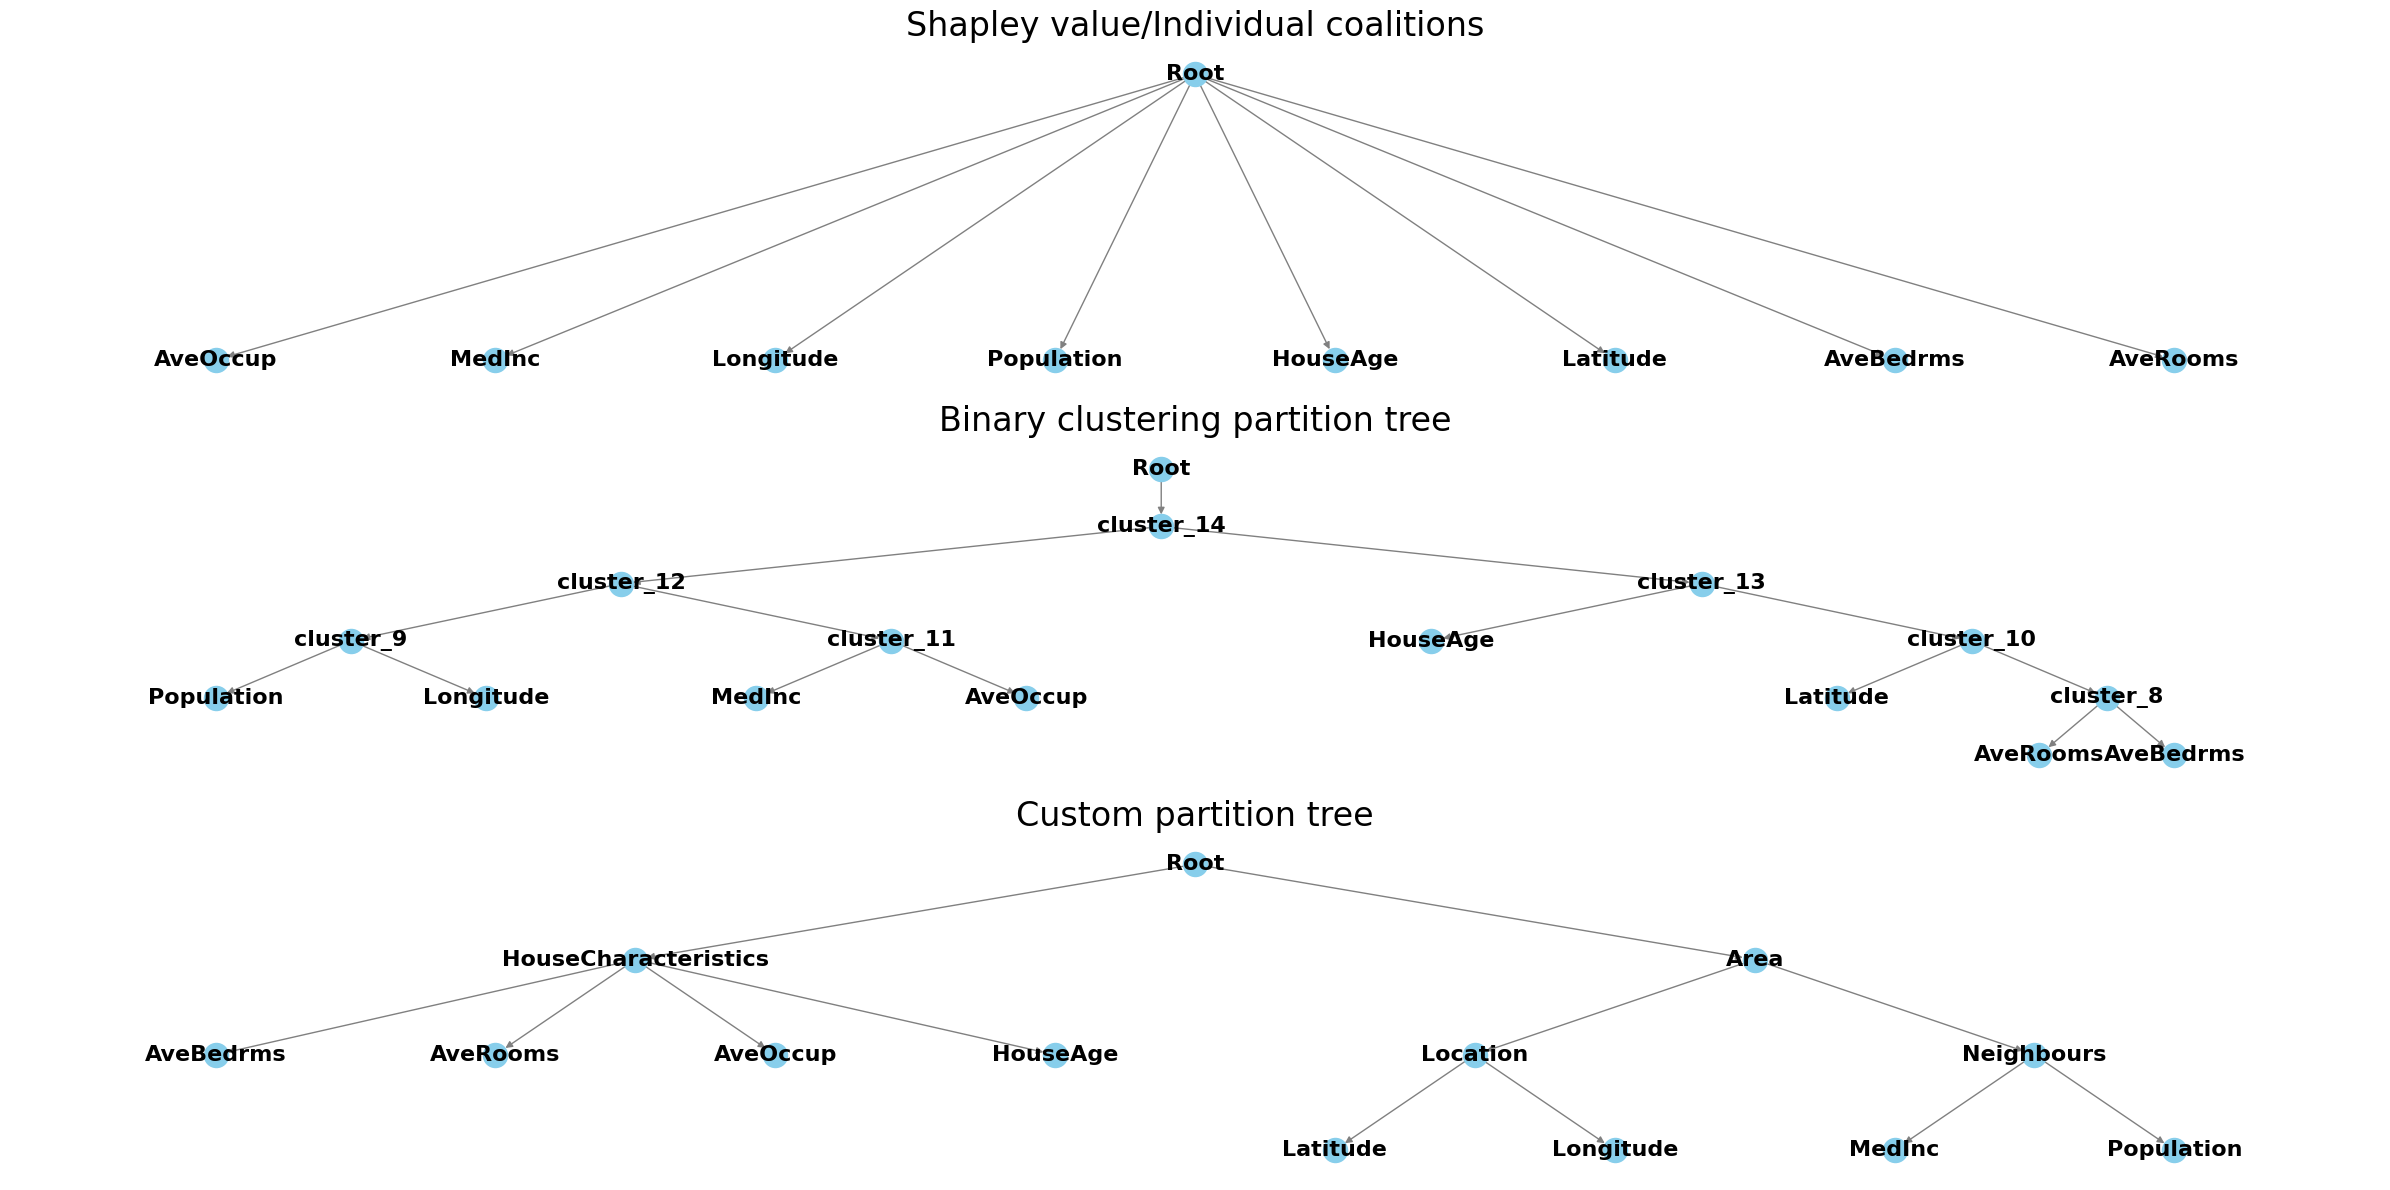

In [10]:
def add_nodes_edges(graph, parent_name, parent_dict):
    for key, value in parent_dict.items():
        if isinstance(value, dict):
            graph.add_node(key)
            graph.add_edge(parent_name, key)
            add_nodes_edges(graph, key, value)
        else:
            graph.add_node(value)
            graph.add_edge(parent_name, value)


def hierarchy_pos(G, root=None, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5):
    pos = _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    return pos


def _hierarchy_pos(
    G,
    root,
    width=1.0,
    vert_gap=0.2,
    vert_loc=0,
    xcenter=0.5,
    pos=None,
    parent=None,
    parsed=[],
):
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)

    children = list(G.neighbors(root))
    if not isinstance(G, nx.DiGraph) and parent is not None:
        children.remove(parent)

    if len(children) != 0:
        dx = width / len(children)
        nextx = xcenter - width / 2 - dx / 2
        for child in children:
            nextx += dx
            pos = _hierarchy_pos(
                G,
                child,
                width=dx,
                vert_gap=vert_gap,
                vert_loc=vert_loc - vert_gap,
                xcenter=nextx,
                pos=pos,
                parent=root,
                parsed=parsed,
            )

    return pos


fig, axes = plt.subplots(3, figsize=(24, 12))

G = nx.DiGraph()
root_name = "Root"
G.add_node(root_name)
add_nodes_edges(G, root_name, hierarchy_flat)
pos = hierarchy_pos(G, root=root_name)
nx.draw(
    G,
    pos,
    with_labels=True,
    arrows=True,
    node_size=300,
    node_color="skyblue",
    font_size=16,
    font_weight="bold",
    edge_color="gray",
    ax=axes[0],
)
axes[0].set_title("Shapley value/Individual coalitions", fontsize=24)

# Plot the first hierarchical tree
G = nx.DiGraph()
root_name = "Root"
G.add_node(root_name)
add_nodes_edges(G, root_name, hierarchy_binary)
pos = hierarchy_pos(G, root=root_name)
nx.draw(
    G,
    pos,
    with_labels=True,
    arrows=True,
    node_size=300,
    node_color="skyblue",
    font_size=16,
    font_weight="bold",
    edge_color="gray",
    ax=axes[1],
)
axes[1].set_title("Binary clustering partition tree", fontsize=24)

# Plot the second hierarchical tree
G = nx.DiGraph()
root_name = "Root"
G.add_node(root_name)
add_nodes_edges(G, root_name, hierarchy_nonbinary)
pos = hierarchy_pos(G, root=root_name)
nx.draw(
    G,
    pos,
    with_labels=True,
    arrows=True,
    node_size=300,
    node_color="skyblue",
    font_size=16,
    font_weight="bold",
    edge_color="gray",
    ax=axes[2],
)
axes[2].set_title("Custom partition tree", fontsize=24)

# Plot the third hierarchical tree


plt.tight_layout()

plt.show()

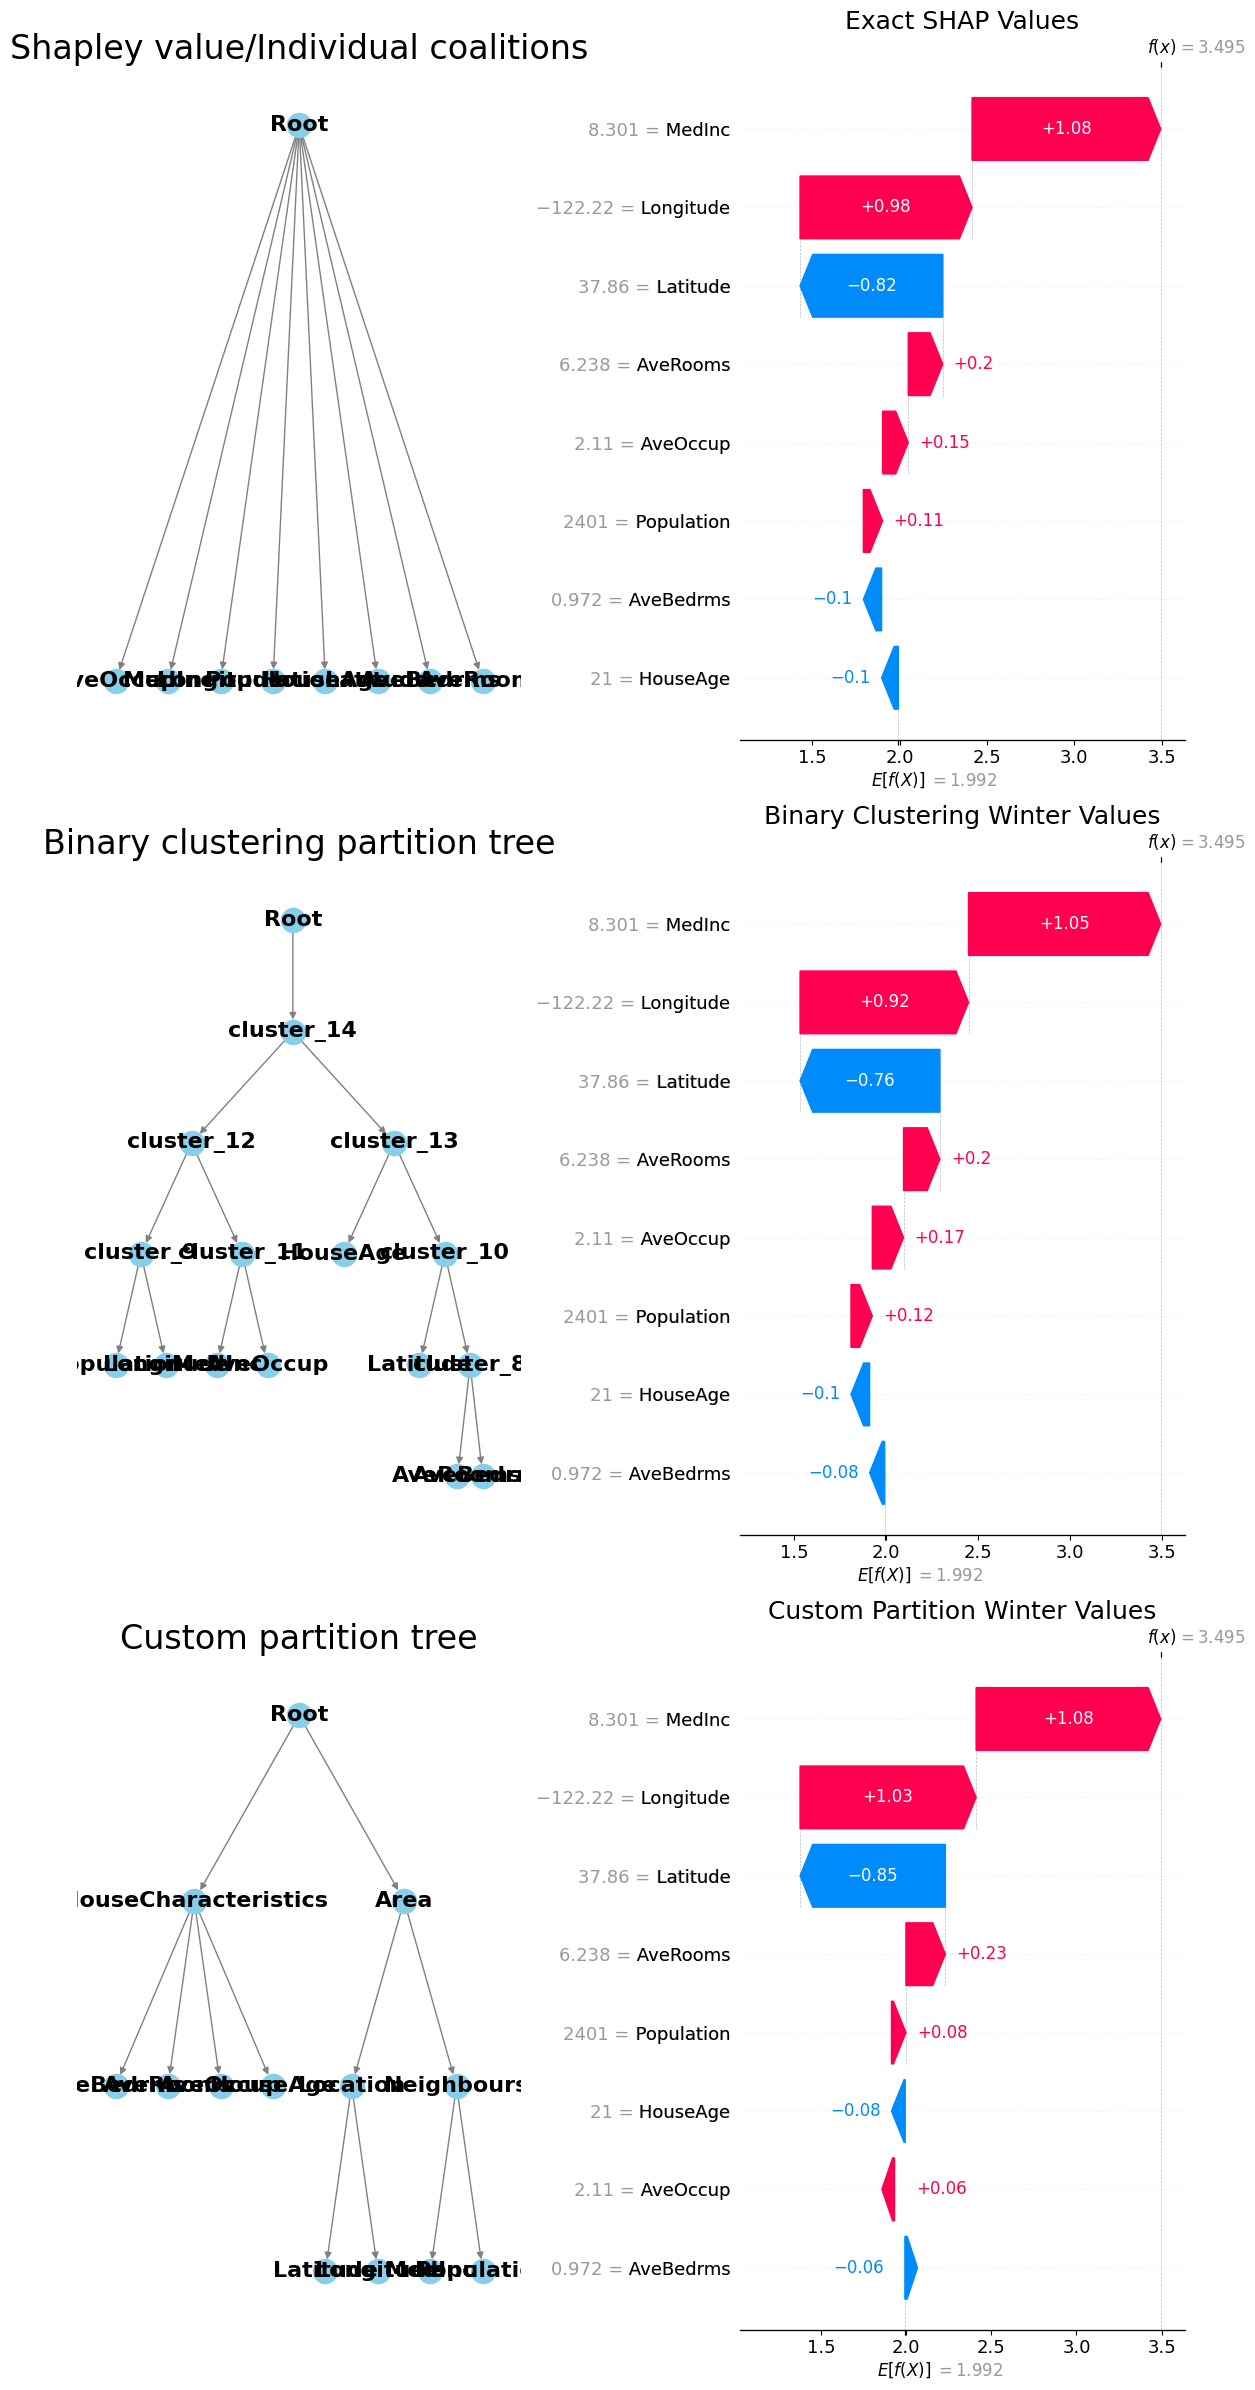

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(24, 36))

# Plot the first hierarchical tree
G = nx.DiGraph()
root_name = "Root"
G.add_node(root_name)
add_nodes_edges(G, root_name, hierarchy_flat)
pos = hierarchy_pos(G, root=root_name)
nx.draw(
    G,
    pos,
    with_labels=True,
    arrows=True,
    node_size=300,
    node_color="skyblue",
    font_size=16,
    font_weight="bold",
    edge_color="gray",
    ax=axes[0, 0],
)
axes[0, 0].set_title("Shapley value/Individual coalitions", fontsize=24)

# Plot the second hierarchical tree
G = nx.DiGraph()
root_name = "Root"
G.add_node(root_name)
add_nodes_edges(G, root_name, hierarchy_binary)
pos = hierarchy_pos(G, root=root_name)
nx.draw(
    G,
    pos,
    with_labels=True,
    arrows=True,
    node_size=300,
    node_color="skyblue",
    font_size=16,
    font_weight="bold",
    edge_color="gray",
    ax=axes[1, 0],
)
axes[1, 0].set_title("Binary clustering partition tree", fontsize=24)

# Plot the third hierarchical tree
G = nx.DiGraph()
root_name = "Root"
G.add_node(root_name)
add_nodes_edges(G, root_name, hierarchy_nonbinary)
pos = hierarchy_pos(G, root=root_name)
nx.draw(
    G,
    pos,
    with_labels=True,
    arrows=True,
    node_size=300,
    node_color="skyblue",
    font_size=16,
    font_weight="bold",
    edge_color="gray",
    ax=axes[2, 0],
)
axes[2, 0].set_title("Custom partition tree", fontsize=24)

# Plot the SHAP waterfall plots
plt.sca(axes[0, 1])
shap.waterfall_plot(exact_shap_values[0], show=False)
plt.gcf().set_size_inches(12, 24)
axes[0, 1].set_title("Exact SHAP Values", fontsize=18)

plt.sca(axes[1, 1])
shap.waterfall_plot(masker_winter_values[0], show=False)
plt.gcf().set_size_inches(12, 24)
axes[1, 1].set_title("Binary Clustering Winter Values", fontsize=18)

plt.sca(axes[2, 1])
shap.waterfall_plot(partition_winter_values_nb2[0], show=False)
plt.gcf().set_size_inches(12, 24)
axes[2, 1].set_title("Custom Partition Winter Values", fontsize=18)

# Adjust layout
plt.tight_layout()

# Save the figure
# plt.savefig(r'C:\Users\azabe\Documents\GitHub\Winter_values\winter_values\hierarchical_trees_and_shap_plots.png')

# Show the plot
plt.show()